# Collaborative filtering


Introduction to basics of recommender systems

## Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from typing import Callable
import pprint

pp = pprint.PrettyPrinter(indent=4)

## Data

{user -> {movie -> rating}}

In [2]:
critics = {
    "Toby": {
        "Snakes on a Plane": 4.5,
        "You, Me and Dupree": 1.0,
        "Superman Returns": 4.0,
    },
    "Lisa Rose": {
        "Lady in the Water": 2.5,
        "Snakes on a Plane": 3.5,
        "Just My Luck": 3.0,
        "Superman Returns": 3.5,
        "You, Me and Dupree": 2.5,
        "The Night Listener": 3.0,
    },
    "Gene Seymour": {
        "Lady in the Water": 3.0,
        "Snakes on a Plane": 3.5,
        "Just My Luck": 1.5,
        "Superman Returns": 5.0,
        "The Night Listener": 3.0,
        "You, Me and Dupree": 3.5,
    },
    "Michael Phillips": {
        "Lady in the Water": 2.5,
        "Snakes on a Plane": 3.0,
        "Superman Returns": 3.5,
        "The Night Listener": 4.0,
    },
    "Claudia Puig": {
        "Snakes on a Plane": 3.5,
        "Just My Luck": 3.0,
        "The Night Listener": 4.5,
        "Superman Returns": 4.0,
        "You, Me and Dupree": 2.5,
    },
    "Mick LaSalle": {
        "Lady in the Water": 3.0,
        "Snakes on a Plane": 4.0,
        "Just My Luck": 2.0,
        "Superman Returns": 3.0,
        "The Night Listener": 3.0,
        "You, Me and Dupree": 2.0,
    },
    "Jack Matthews": {
        "Lady in the Water": 3.0,
        "Snakes on a Plane": 4.0,
        "The Night Listener": 3.0,
        "Superman Returns": 5.0,
        "You, Me and Dupree": 3.5,
    },
}


## Distance and similarity


Here we calculate similarity between users based on the Euclidian and Pearson distances

### Similarity

$$s(x,y) = \frac{1}{1 + d(x, y)}$$

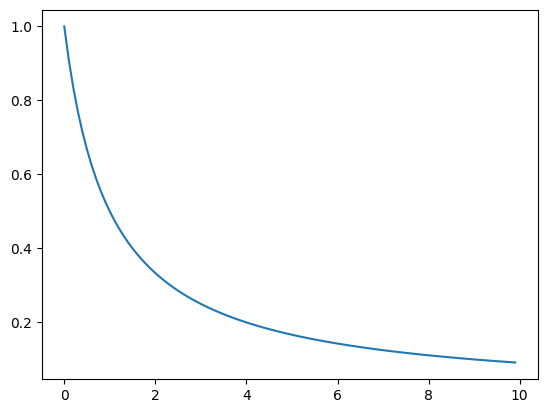

In [3]:
f = lambda x: 1 / (1 + x)
x = np.arange(0., 10., 0.1)

plt.plot(x, f(x))

### Euclidian distance

$$d(x,y) = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}$$

In [4]:
def similar_films(critics: dict, left_person: str, right_person: str) -> list:
    """Return list of films rated by both users"""
    sim_films = []

    for film in critics[left_person]:
        if film in critics[right_person]:
            sim_films.append(film)

    return sim_films

In [5]:
def sim_distance(critics: dict, left_person: str, right_person: str) -> float:
    """Calculates euclidian distance based similarity score for persons"""

    sim_films = similar_films(critics, left_person, right_person)
    euclid_dist_sum = 0
    for film in sim_films:
        euclid_dist_sum += (critics[left_person][film] - critics[right_person][film])**2

    return 1 / (1 + euclid_dist_sum**0.5)

In [6]:
sim_distance(critics, "Lisa Rose", "Toby")

0.3483314773547883

In [7]:
dist_sim_vals = np.zeros((len(critics), len(critics)))

for i, source in enumerate(critics):
    for j, referer in enumerate(critics):
        dist_sim_vals[i, j] = sim_distance(critics, source, referer)

print(dist_sim_vals.round(3))
print(dist_sim_vals.mean(), dist_sim_vals.std())

[[1.    0.348 0.258 0.387 0.357 0.4   0.267]
 [0.348 1.    0.294 0.472 0.387 0.414 0.341]
 [0.258 0.294 1.    0.341 0.282 0.278 0.667]
 [0.387 0.472 0.341 1.    0.536 0.387 0.32 ]
 [0.357 0.387 0.282 0.536 1.    0.315 0.32 ]
 [0.4   0.414 0.278 0.387 0.315 1.    0.286]
 [0.267 0.341 0.667 0.32  0.32  0.286 1.   ]]
0.4554311978920751 0.23926368288388913


In [8]:
# mean and std over distinct distances

tirangle_mask = np.tri(len(critics), k=-1, dtype=np.bool_)
print(tirangle_mask)

norm_dist_sim_vals = dist_sim_vals[tirangle_mask]
print(norm_dist_sim_vals.round(3))
print(norm_dist_sim_vals.mean(), norm_dist_sim_vals.std())

[[False False False False False False False]
 [ True False False False False False False]
 [ True  True False False False False False]
 [ True  True  True False False False False]
 [ True  True  True  True False False False]
 [ True  True  True  True  True False False]
 [ True  True  True  True  True  True False]]
[0.348 0.258 0.294 0.387 0.472 0.341 0.357 0.387 0.282 0.536 0.4   0.414
 0.278 0.387 0.315 0.267 0.341 0.667 0.32  0.32  0.286]
0.3646697308740877 0.09552375448837512


In [9]:
import matplotlib.pyplot as plt


def plot_pdf(values: np.ndarray, title: str):
    """Plots `values` distribution density"""
    plt.figure(figsize=(10, 5))
    plt.violinplot(values.flatten(), vert=False, showmedians=True)
    plt.xlabel("Similarity")
    plt.grid()
    plt.title(title)
    plt.show()

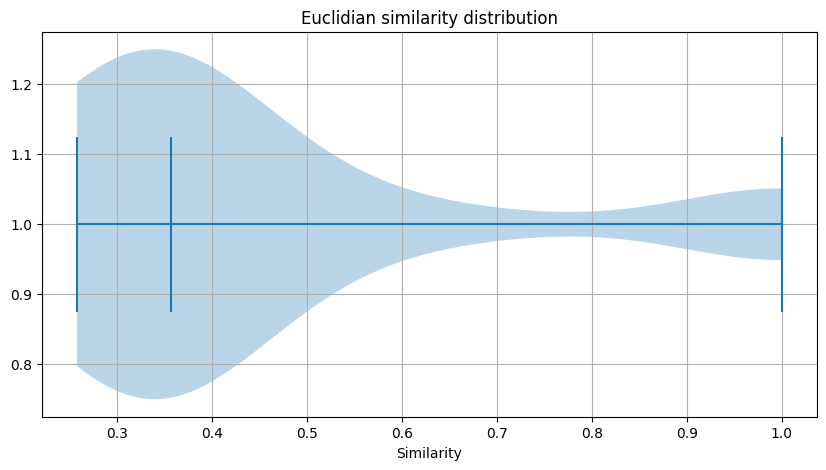

In [10]:
plot_pdf(dist_sim_vals, "Euclidian similarity distribution")

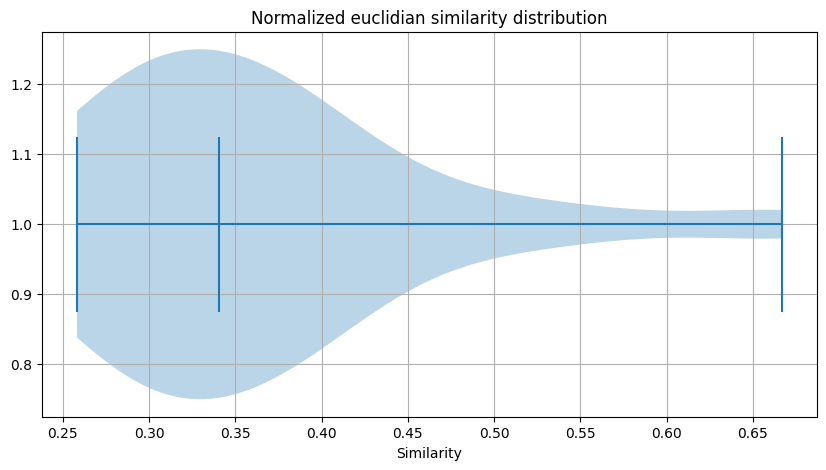

In [11]:
plot_pdf(norm_dist_sim_vals, "Normalized euclidian similarity distribution")

### Pearson correlation as a distance

$$\textrm{corr}(x,y) = \frac{E[(X-E[X])\cdot (Y-E[Y])]}{\sqrt{D[X]D[Y]}} =  \frac{\sum_{i=1}^n (x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^n(x_i-\bar{x})^2 \sum_{i=1}^n(y_i - \bar{y})^2}}$$

In [12]:
from math import isnan

from scipy.stats import pearsonr


def sim_pearson(critics_dict, left_person, right_person):
    """Calculates pearson correlation based similarity between persons"""
    sim_films = similar_films(critics_dict, left_person, right_person)

    if len(sim_films) < 2:
        return 0

    scores_left = []
    scores_right = []
    for film in sim_films:
        scores_left.append(critics_dict[left_person][film])
        scores_right.append(critics_dict[right_person][film])

    correlation = pearsonr(scores_left, scores_right)[0]

    return correlation


In [13]:
print(sim_pearson(critics, "Lisa Rose", "Gene Seymour"))
print(sim_pearson(critics, "Lisa Rose", "Toby"))

0.3960590171906697
0.9912407071619302


In [14]:
dist_pear_vals = np.zeros((len(critics), len(critics)))

for i, source in enumerate(critics):
    for j, referer in enumerate(critics):
        dist_pear_vals[i, j] = sim_pearson(critics, source, referer)

print(dist_pear_vals.round(3))
print(dist_pear_vals.mean(), dist_pear_vals.std())


[[ 1.     0.991  0.381 -1.     0.893  0.924  0.663]
 [ 0.991  1.     0.396  0.405  0.567  0.594  0.747]
 [ 0.381  0.396  1.     0.205  0.315  0.412  0.964]
 [-1.     0.405  0.205  1.     1.    -0.258  0.135]
 [ 0.893  0.567  0.315  1.     1.     0.567  0.029]
 [ 0.924  0.594  0.412 -0.258  0.567  1.     0.211]
 [ 0.663  0.747  0.964  0.135  0.029  0.211  1.   ]]
0.5159356584296166 0.47132528276359864


In [15]:
tirangle_mask = np.tri(len(critics), k=-1, dtype=np.bool_)
norm_pear_sim_vals = dist_pear_vals[tirangle_mask]
norm_pear_sim_vals.round(3)

print(norm_pear_sim_vals.mean(), norm_pear_sim_vals.std())

0.43525826816788604 0.462179856879093


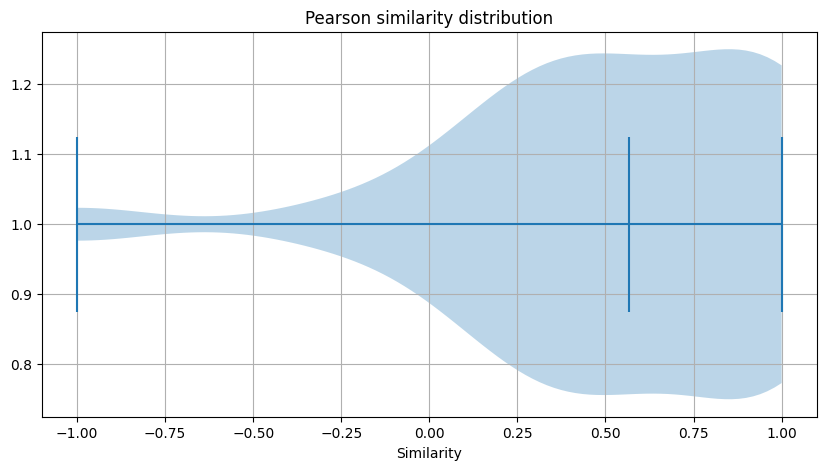

In [16]:
plot_pdf(dist_pear_vals, "Pearson similarity distribution")

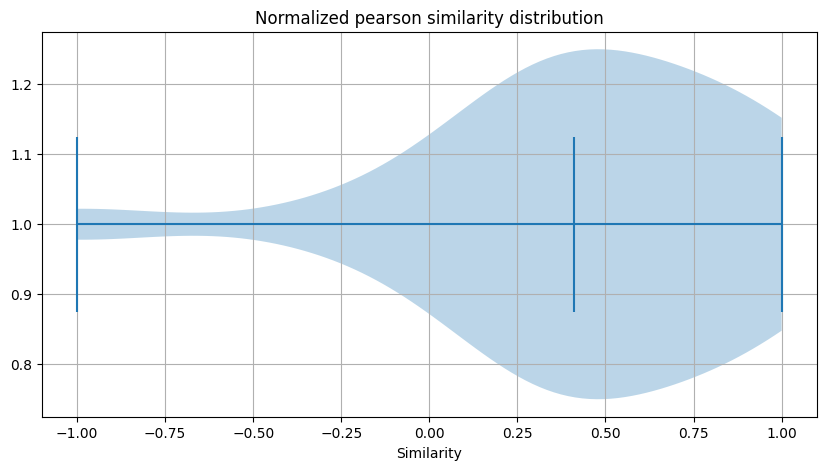

In [17]:
plot_pdf(norm_pear_sim_vals, "Normalized pearson similarity distribution")


## Ranking

Here we create a function to find top-n similar users for a given one

In [26]:
def top_matches(
        critics: dict, person: str, n: int = 5, similarity_fn: Callable = sim_pearson
):
    """Returns top-n most similar critics"""
    scores = []

    for other in critics:
        if other == person:
            continue

        similarity_score = similarity_fn(critics, person, other)
        scores.append((similarity_score, other))

    scores.sort(reverse=True)

    return scores[0:n]

In [ ]:
top_matches(critics, "Toby", n=3, similarity_fn=sim_pearson)


[(np.float64(0.9912407071619302), 'Lisa Rose'),
 (np.float64(0.9244734516419049), 'Mick LaSalle'),
 (np.float64(0.8934051474415643), 'Claudia Puig')]

In [ ]:
pp.pprint(
    {k: v for k, v in critics.items() if k in ("Toby", "Mick LaSalle", "Lisa Rose", "Claudia Puig")}
)


{   'Claudia Puig': {   'Just My Luck': 3.0,
                        'Snakes on a Plane': 3.5,
                        'Superman Returns': 4.0,
                        'The Night Listener': 4.5,
                        'You, Me and Dupree': 2.5},
    'Lisa Rose': {   'Just My Luck': 3.0,
                     'Lady in the Water': 2.5,
                     'Snakes on a Plane': 3.5,
                     'Superman Returns': 3.5,
                     'The Night Listener': 3.0,
                     'You, Me and Dupree': 2.5},
    'Mick LaSalle': {   'Just My Luck': 2.0,
                        'Lady in the Water': 3.0,
                        'Snakes on a Plane': 4.0,
                        'Superman Returns': 3.0,
                        'The Night Listener': 3.0,
                        'You, Me and Dupree': 2.0},
    'Toby': {   'Snakes on a Plane': 4.5,
                'Superman Returns': 4.0,
                'You, Me and Dupree': 1.0}}


In [ ]:
top_matches(critics, "Toby", n=3, similarity_fn=sim_distance)


[(0.4, 'Mick LaSalle'),
 (0.38742588672279304, 'Michael Phillips'),
 (0.3567891723253309, 'Claudia Puig')]

In [ ]:
pp.pprint(
    {k: v for k, v in critics.items() if k in ("Toby", "Mick LaSalle", "Michael Phillips", "Claudia Puig")}
)


{   'Claudia Puig': {   'Just My Luck': 3.0,
                        'Snakes on a Plane': 3.5,
                        'Superman Returns': 4.0,
                        'The Night Listener': 4.5,
                        'You, Me and Dupree': 2.5},
    'Michael Phillips': {   'Lady in the Water': 2.5,
                            'Snakes on a Plane': 3.0,
                            'Superman Returns': 3.5,
                            'The Night Listener': 4.0},
    'Mick LaSalle': {   'Just My Luck': 2.0,
                        'Lady in the Water': 3.0,
                        'Snakes on a Plane': 4.0,
                        'Superman Returns': 3.0,
                        'The Night Listener': 3.0,
                        'You, Me and Dupree': 2.0},
    'Toby': {   'Snakes on a Plane': 4.5,
                'Superman Returns': 4.0,
                'You, Me and Dupree': 1.0}}


## User-based approach

For a given user iterate over all other users and

1) Calculate their similarity (consider only those with sim > 0)

2) For each item add a weighted rating of this item

3) Calculate weighted average score for each candidate item and then sort in descending order

In [19]:
def get_recommendations(prefs: dict, person: str, similarity: Callable = sim_pearson):
    """Calculates recomendations for a `person` using weighted mean from `prefs`"""
    totals = {}     # Stores the weighted sum of ratings for each unseen item
    sim_sums = {}   # Stores the total similarity scores for each unseen item

    # Iterate over every other user in the dataset
    for other in critics:
        if other == person:
            continue  # Skip comparing the person to themselves

        # Compute similarity score between the target user and this other user
        sim = similarity(critics, person, other)

        # Ignore users with zero or negative similarity
        if sim <= 0:
            continue

        # Go through every item rated by this other user
        for item in critics[other]:
            # Consider only items that the target user hasn't rated or has a rating of 0
            if item not in critics[person] or critics[person][item] == 0:
                # Add weighted rating (rating × similarity)
                totals.setdefault(item, 0)
                totals[item] += critics[other][item] * sim

                # Accumulate similarity scores for normalization later
                sim_sums.setdefault(item, 0)
                sim_sums[item] += sim

    # Calculate weighted average score for each candidate item
    rankings = [(total / sim_sums[item], item) for item, total in totals.items()]

    # Sort the list in descending order of predicted rating
    rankings.sort(reverse=True)

    return rankings

In [21]:
print(get_recommendations(critics, "Toby", sim_pearson))
print(critics["Toby"])
print(get_recommendations(critics, "Toby", sim_distance))

[(np.float64(3.347789526713101), 'The Night Listener'), (np.float64(2.832549918264162), 'Lady in the Water'), (np.float64(2.530980703765565), 'Just My Luck')]
{'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}
[(3.457128694491423, 'The Night Listener'), (2.778584003814924, 'Lady in the Water'), (2.422482042361917, 'Just My Luck')]


## Item-based collaborative filtering

Transposing the user-based approach

Idea: We recommend similar items to those user liked

In [22]:
def transform_prefs(critics: dict) -> dict:
    """Inverts nested dict of critics-films-scores into films-critics-scores dict"""
    result = {}

    for person in critics:
        for item in critics[person]:
            result.setdefault(item, {})
            result[item][person] = critics[person][item]

    return result

In [25]:
def calculate_similar_items(prefs: dict, n: int = 10, similarity_fn: Callable = sim_distance):
    """Creates a dict with most similar items for each item"""
    result = {}

    # Convert user-based prefs to item-based prefs
    item_prefs = transform_prefs(prefs)

    c = 0  # Counter for progress tracking

    # Iterate over each item in the dataset
    for item in item_prefs:
        c += 1

        # Find the top N similar items for this item
        scores = top_matches(item_prefs, item, n=n, similarity_fn=similarity_fn)
        result[item] = scores

        # Optional progress output every 100 items
        if c % 100 == 0:
            print("%d / %d" % (c, len(item_prefs)))

    return result


In [28]:
itemsim = calculate_similar_items(critics, n=10)
pp.pprint(itemsim)


{   'Just My Luck': [   (0.3483314773547883, 'Lady in the Water'),
                        (0.32037724101704074, 'You, Me and Dupree'),
                        (0.2989350844248255, 'The Night Listener'),
                        (0.2553967929896867, 'Snakes on a Plane'),
                        (0.20799159651347807, 'Superman Returns')],
    'Lady in the Water': [   (0.4494897427831781, 'You, Me and Dupree'),
                             (0.38742588672279304, 'The Night Listener'),
                             (0.3483314773547883, 'Snakes on a Plane'),
                             (0.3483314773547883, 'Just My Luck'),
                             (0.2402530733520421, 'Superman Returns')],
    'Snakes on a Plane': [   (0.3483314773547883, 'Lady in the Water'),
                             (0.32037724101704074, 'The Night Listener'),
                             (0.3090169943749474, 'Superman Returns'),
                             (0.2553967929896867, 'Just My Luck'),
                   

In [29]:
itemsim["Superman Returns"]


[(0.3090169943749474, 'Snakes on a Plane'),
 (0.252650308587072, 'The Night Listener'),
 (0.2402530733520421, 'Lady in the Water'),
 (0.20799159651347807, 'Just My Luck'),
 (0.1918253663634734, 'You, Me and Dupree')]

In [30]:
def get_recommended_items(prefs: dict, item_match: dict, user: str):
    """Calculates recomendations for `user` using mean scores based on items similarity"""

    # All items the target user has already rated
    user_ratings = prefs[user]

    # Accumulate weighted scores for candidate items
    scores = {}
    # Accumulate total similarity values for normalization
    total_sim = {}

    # Loop over each item the user has rated
    for item, rating in user_ratings.items():
        # Loop over items similar to this one
        for similarity, item2 in item_match[item]:
            # Skip items the user has already rated
            if item2 in user_ratings:
                continue

            # Weighted sum of rating × similarity
            scores.setdefault(item2, 0)
            scores[item2] += similarity * rating

            # Sum of similarities (for later normalization)
            total_sim.setdefault(item2, 0)
            total_sim[item2] += similarity

            # Prevent division by zero later
            if total_sim[item2] == 0:
                total_sim[item2] = 1e-7

    # Normalize weighted sums by total similarity to get predicted ratings
    rankings = [(score / total_sim[item], item) for item, score in scores.items()]

    # Sort recommendations by predicted rating in descending order
    rankings.sort(reverse=True)

    return rankings

In [32]:
get_recommended_items(critics, itemsim, "Toby")

[(3.1667425234070894, 'The Night Listener'),
 (2.9366294028444346, 'Just My Luck'),
 (2.868767392626467, 'Lady in the Water')]